# Installation

In [2]:
!pip install -U gensim

Requirement already up-to-date: gensim in d:\anconda\lib\site-packages (4.0.1)


In [46]:
!pip install yellowbrick

In [55]:
!pip install bert-for-tf2

  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30537 sha256=3dcf8e6b8cdfd4bf97364d5a5781bd8d9462c2097a2136bd44b3b4f266981e3e
  Stored in directory: c:\users\princ\appdata\local\pip\cache\wheels\ab\a4\72\df07592cea3ae06b5e846f5e52262f8b16748e829ca354b7df
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7916 sha256=997e4e09aa2ee1b4189efcae96791c66b0c302304f57b94caad27bac8a7ad4c3
  Stored in directory: c:\users\princ\appdata\local\pip\cache\wheels\ac\26\e9\df16869ccbd4abf517f1ff3be9a2c7ee5c5980fc87eea04fb1
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19476 sha256=1625674b187b23356850874af686be1fcc54ec495680aa776dc1d2510199a8f2
  Stored in directory: c:\users\princ\appdata\local\pip\cache\wheels\c7\f3\85\b8cf1d8bfe55dc2ece0f1fcd4e91d6f8fc7b59ff3fd75329e1
Successfully built bert-for-tf2 py-params params-flow


In [60]:
!pip install tensorflow_hub

# Import

In [3]:
# import libraries
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk import bigrams
from nltk import trigrams
import  collections
import gensim
from gensim.models import Word2Vec
from sklearn.metrics import silhouette_score,silhouette_samples
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input, Dropout
from tensorflow.keras.optimizers import Adam



D:\Anconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\princ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
data = pd.read_csv("./data/flipkart_com-ecommerce_sample_1050.csv")
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [6]:
corpus = data[['description']]
corpus.head(3)

,description
0,Key Features of Elegance Polyester Multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...


In [7]:
corpus.shape

(1050, 1)

#  Récupération des catégories principales

In [8]:
data['main_cat'] = data.product_category_tree.str.split(">>",expand=True,)[0]
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_cat
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[""Home Furnishing"
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","[""Baby Care"
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...","[""Baby Care"
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...","[""Home Furnishing"
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...","[""Home Furnishing"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...","[""Baby Care"
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...","[""Baby Care"
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...","[""Baby Care"
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:

In [9]:
data['main_cat'] = data['main_cat'].str.replace(r'"', '')
data['main_cat'] = data['main_cat'].str.replace(r'[', '')
data['main_cat'] = data['main_cat'].str.replace(r']', '')

<ipython-input-9-ae0145373f22>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['main_cat'] = data['main_cat'].str.replace(r'[', '')
<ipython-input-9-ae0145373f22>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['main_cat'] = data['main_cat'].str.replace(r']', '')


In [10]:
data['main_cat'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

# Data preprocessing

In [11]:
dataMini = data[['main_cat','description']]
dataMini

,main_cat,description
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...
1046,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [12]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
dataMini["text_clean"] = dataMini["description"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dataMini.head()

<ipython-input-14-cfaf4699e1bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMini["text_clean"] = dataMini["description"].apply(lambda x:


,main_cat,description,text_clean
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...
3,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,key feature santosh royal fashion cotton print...
4,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,key feature jaipur print cotton floral king si...


## Split dataset

In [16]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dataMini, test_size=0.3)
## get target
y_train = dtf_train["main_cat"].values
y_test = dtf_test["main_cat"].values

# N-gram

In [17]:
# generate unigrams bigrams trigrams

unigram=[]
bigram=[]
trigram=[]
tokenized_text=[]

for sentence in dataMini['text_clean']:
    unigram.extend(unigram)
    bigram.extend(bigrams(sentence.split(' ')))
    trigram.extend(trigrams(sentence.split(' ')))

In [18]:
bigramFreq = collections.Counter(bigram)
bigramFreq

Counter({('key', 'feature'): 207,
         ('feature', 'elegance'): 1,
         ('elegance', 'polyester'): 2,
         ('polyester', 'multicolor'): 4,
         ('multicolor', 'abstract'): 3,
         ('abstract', 'eyelet'): 4,
         ('eyelet', 'door'): 14,
         ('door', 'curtain'): 26,
         ('curtain', 'floral'): 1,
         ('floral', 'curtainelegance'): 1,
         ('curtainelegance', 'polyester'): 1,
         ('curtain', '213'): 4,
         ('213', 'cm'): 9,
         ('cm', 'height'): 22,
         ('height', 'pack'): 12,
         ('pack', '2'): 61,
         ('2', 'price'): 15,
         ('price', 'r'): 342,
         ('r', '899'): 5,
         ('899', 'curtain'): 1,
         ('curtain', 'enhances'): 1,
         ('enhances', 'look'): 1,
         ('look', 'interiorsthis'): 1,
         ('interiorsthis', 'curtain'): 1,
         ('curtain', 'made'): 1,
         ('made', '100'): 8,
         ('100', 'high'): 2,
         ('high', 'quality'): 69,
         ('quality', 'polyester'): 3,

In [19]:
trigramFreq = collections.Counter(trigram)
trigramFreq

Counter({('key', 'feature', 'elegance'): 1,
         ('feature', 'elegance', 'polyester'): 1,
         ('elegance', 'polyester', 'multicolor'): 2,
         ('polyester', 'multicolor', 'abstract'): 3,
         ('multicolor', 'abstract', 'eyelet'): 3,
         ('abstract', 'eyelet', 'door'): 3,
         ('eyelet', 'door', 'curtain'): 14,
         ('door', 'curtain', 'floral'): 1,
         ('curtain', 'floral', 'curtainelegance'): 1,
         ('floral', 'curtainelegance', 'polyester'): 1,
         ('curtainelegance', 'polyester', 'multicolor'): 1,
         ('door', 'curtain', '213'): 4,
         ('curtain', '213', 'cm'): 4,
         ('213', 'cm', 'height'): 4,
         ('cm', 'height', 'pack'): 12,
         ('height', 'pack', '2'): 7,
         ('pack', '2', 'price'): 11,
         ('2', 'price', 'r'): 15,
         ('price', 'r', '899'): 5,
         ('r', '899', 'curtain'): 1,
         ('899', 'curtain', 'enhances'): 1,
         ('curtain', 'enhances', 'look'): 1,
         ('enhances', 'loo

# Features extraction

## TF-IDF

In [20]:
tf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

## bag of words

In [21]:
## Count (classic BoW)
bow_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))

## BERT

In [62]:
import tensorflow_hub as hub

# module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)



Failed to import tensorflow. Please note that tensorflow is not installed by default when you install tensorflow_hub. This is so that users can decide which tensorflow package to use. To use tensorflow_hub, please install a current version of tensorflow by following the instructions at https://tensorflow.org/install and https://tensorflow.org/hub/installation.




ModuleNotFoundError: No module named 'tensorflow'

In [57]:
import numpy as np

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

## Doc2vec

In [64]:
tokenized_sent = []
for s in dataMini['text_clean']:
    tokenized_sent.append(word_tokenize(s.lower()))

In [65]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]
tagged_data

[TaggedDocument(words=['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtainelegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2', 'price', 'r', '899', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', '100', 'high', 'quality', 'polyester', 'fabricit', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'make', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print'

In [67]:
model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 1, epochs = 100)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

## Print model vocabulary
words = list(model.wv.index_to_key)

In [68]:
words

['product',
 'free',
 'r',
 'buy',
 'delivery',
 'cash',
 'genuine',
 'shipping',
 'price',
 'replacement',
 'day',
 'cm',
 '30',
 'flipkartcom',
 'guarantee',
 'mug',
 '1',
 'feature',
 'online',
 'watch',
 'color',
 'type',
 'baby',
 'pack',
 'material',
 'set',
 'box',
 'general',
 'cotton',
 'package',
 'sale',
 'design',
 'analog',
 'number',
 'warranty',
 'detail',
 'quality',
 'girl',
 'brand',
 'laptop',
 'best',
 'key',
 'inch',
 'model',
 'ceramic',
 'showpiece',
 'fabric',
 'size',
 'great',
 'made',
 'perfect',
 'boy',
 'gift',
 'india',
 'men',
 'dimension',
 'usb',
 '2',
 'skin',
 'home',
 'ideal',
 'multicolor',
 'specification',
 'content',
 'one',
 'combo',
 'cover',
 'light',
 'woman',
 'water',
 'x',
 'print',
 'printed',
 'discount',
 'adapter',
 'width',
 'wash',
 'black',
 'battery',
 'give',
 'also',
 'care',
 'power',
 'ml',
 '4',
 'coffee',
 'height',
 'yes',
 'pattern',
 'high',
 '6',
 'style',
 'use',
 '3',
 'blue',
 'length',
 'towel',
 'name',
 'come',
 'ea

In [69]:
test_doc = word_tokenize("I had pizza and pasta".lower())
test_doc_vector = model.infer_vector(test_doc)
model.docvecs.most_similar(positive = [test_doc_vector])

<ipython-input-69-4a3c7f85d5c6>:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs.most_similar(positive = [test_doc_vector])


[(215, 0.8417026996612549),
 (235, 0.8412955403327942),
 (218, 0.8221920132637024),
 (216, 0.8147127628326416),
 (192, 0.7921577095985413),
 (199, 0.7708417773246765),
 (223, 0.7537060379981995),
 (657, 0.741750955581665),
 (176, 0.7414223551750183),
 (177, 0.7248616814613342)]

# Create train corpus

In [37]:
def createInput(vectorizer):
    corpus = dtf_train["text_clean"]
    vectorizer.fit(corpus)
    X_train = vectorizer.transform(corpus)
    return X_train

# Classifier

In [23]:
classifier = naive_bayes.MultinomialNB()

In [24]:
kmeans = KMeans(n_clusters = 7, n_init = 17, n_jobs = -1, tol = 0.01, max_iter = 200)
def cluster_kmeans(vect):
    #setup kmeans clustering
    #fit the data 
    kmeans.fit(vect)
    #this loop transforms the numbers back into words
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-20:-1]
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

# Pipeline

In [26]:
def createPipeline(classifier,vectorizer):
    ## pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## Create X_train 
    X_train = createInput(vectorizer)
    
    ## train classifier
    model["classifier"].fit(X_train, y_train)
    
    ## test
    X_test = dtf_test["text_clean"].values
    predicted = model.predict(X_test)
    return predicted

Nous allons créer des pipeline pour tous les extracteur de features :

In [41]:
tf_predicted = createPipeline(classifier,tf_vectorizer)

In [42]:
bow_predicted = createPipeline(classifier,bow_vectorizer)

# Evolution de performance

## Précision et recall

In [35]:
def calcul_performance(predicted):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values

    accuracy = metrics.accuracy_score(y_test, predicted)
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))

Nous allons evoluer la performance de classifier avec chacun d'extracteur de feature

In [39]:
calcul_performance(tf_predicted)

Accuracy: 0.91
Detail:
                             precision    recall  f1-score   support

                 Baby Care        0.93      0.77      0.84        35
  Beauty and Personal Care        0.98      0.93      0.96        59
                 Computers        0.74      1.00      0.85        39
Home Decor & Festive Needs        0.98      0.96      0.97        48
           Home Furnishing        0.80      1.00      0.89        32
          Kitchen & Dining        0.97      0.75      0.85        52
                   Watches        1.00      1.00      1.00        50

                   accuracy                           0.91       315
                  macro avg       0.91      0.92      0.91       315
               weighted avg       0.93      0.91      0.91       315



In [43]:
calcul_performance(bow_predicted)

Accuracy: 0.87
Detail:
                             precision    recall  f1-score   support

                 Baby Care        0.96      0.74      0.84        35
  Beauty and Personal Care        0.71      0.93      0.80        59
                 Computers        0.93      0.69      0.79        39
Home Decor & Festive Needs        0.88      0.96      0.92        48
           Home Furnishing        0.80      1.00      0.89        32
          Kitchen & Dining        0.97      0.73      0.84        52
                   Watches        1.00      1.00      1.00        50

                   accuracy                           0.87       315
                  macro avg       0.89      0.87      0.87       315
               weighted avg       0.89      0.87      0.87       315



## Matrice de confusion 

In [31]:
def createConfusionMatrix(predicted):
    classes = np.unique(y_test)

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=30)

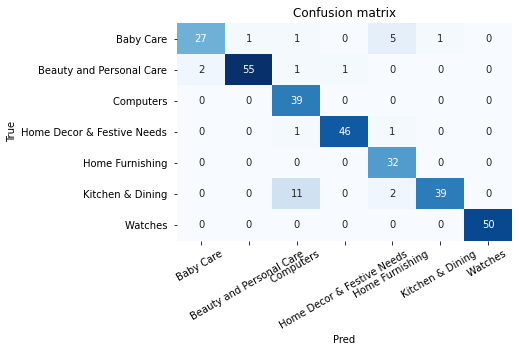

In [40]:
createConfusionMatrix(tf_predicted)

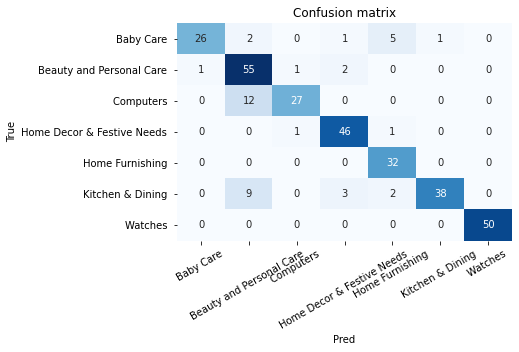

In [44]:
createConfusionMatrix(bow_predicted)

## Adjusted Rand Index

In [52]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(y_test, tf_predicted)

0.8269989428357786

In [53]:
adjusted_rand_score(y_test, bow_predicted)

0.7197365338908746

# Sillouhaite Score Analysis

In [78]:
X= bow_vectorizer.fit_transform(dataMini['text_clean'])
X

<1050x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 77566 stored elements in Compressed Sparse Row format>

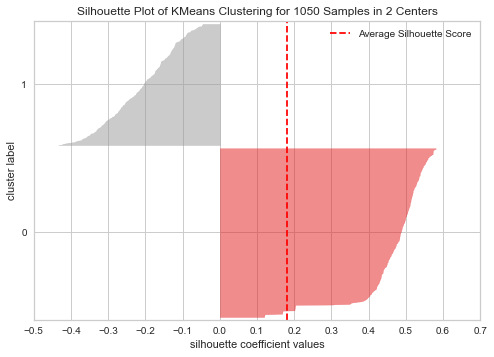

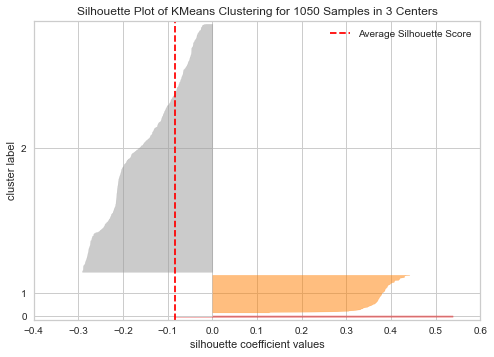

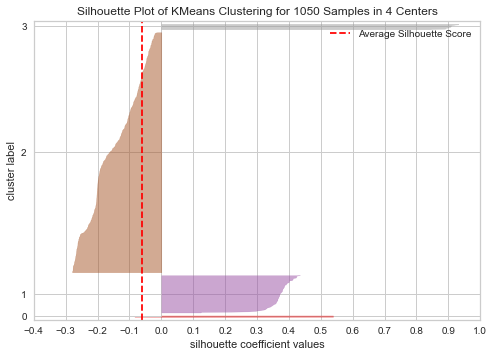

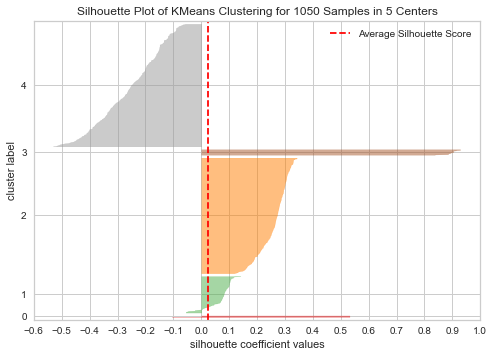

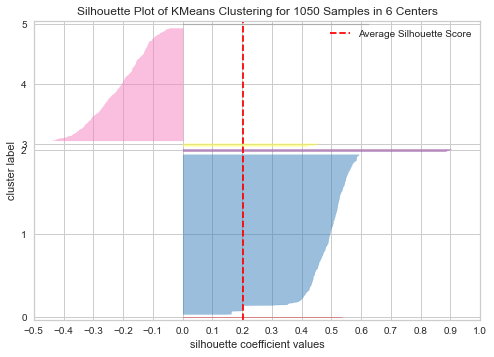

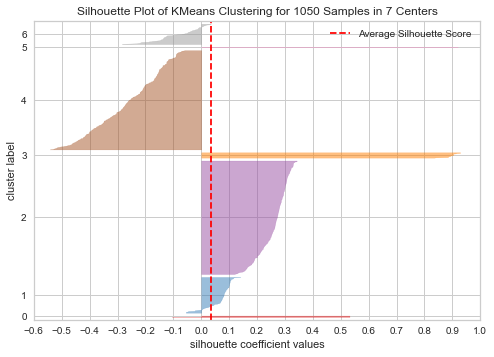

In [102]:
from yellowbrick.cluster import SilhouetteVisualizer

wcss = []

for i in range(2,8):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter= 300, random_state= 42)
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(X)
    visualizer.show()
    wcss.append(kmeans.inertia_)   

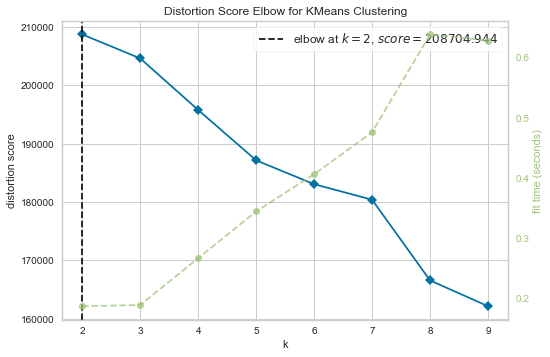

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(2,10))
 
visualizer.fit(X)
visualizer.show()   

# T-SNE

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

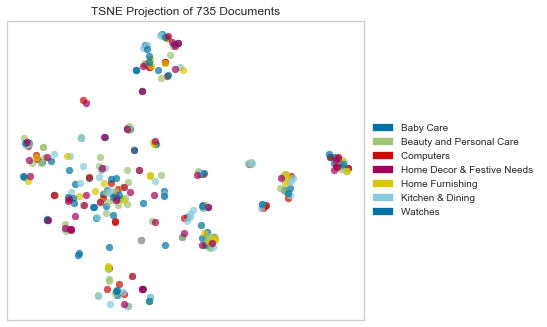

<AxesSubplot:title={'center':'TSNE Projection of 735 Documents'}>

In [50]:
X = createInput(tf_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

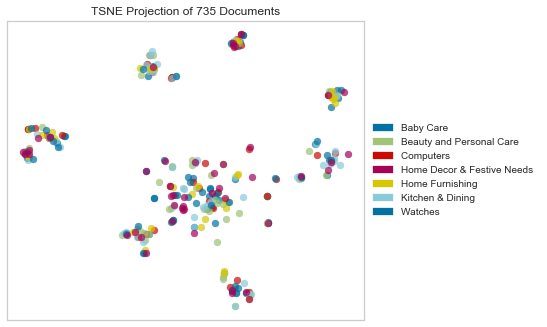

<AxesSubplot:title={'center':'TSNE Projection of 735 Documents'}>

In [51]:
X = createInput(bow_vectorizer)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y_test)
tsne.show()